In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, BatchNormalization, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import json
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import matplotlib as plt

#### Import data and take 200.000 random reviews

In [2]:
# Load Data
reviews_df = pd.read_csv('Reviews.csv', on_bad_lines='skip')

reviews_df['Review'] = reviews_df['Review'].astype('string')
reviews_df = reviews_df.dropna(subset=['Rating_binary'])
reviews_df['Rating_binary'] = reviews_df['Rating_binary'].astype(int)
# reduce data to 200 thousand review based on label
# df_label_0 = reviews_df[reviews_df['label'] == 0].sample(n=100000, random_state=42)
# df_label_1 = reviews_df[reviews_df['label'] == 1].sample(n=100000, random_state=42)

# # Combine and shuffle
# df_reduced = pd.concat([df_label_0, df_label_1]).sample(frac=1, random_state=42).reset_index(drop=True)

# reviews_df = df_reduced
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15140 entries, 0 to 15152
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Game Name      15140 non-null  object
 1   Review         15112 non-null  string
 2   Rating_binary  15140 non-null  int64 
 3   Date           15140 non-null  object
dtypes: int64(1), object(2), string(1)
memory usage: 591.4+ KB


In [3]:
reviews_df.head()

,Game Name,Review,Rating_binary,Date
0,tryHackMe,It's great platform for fresher to start there...,1,"Apr 7, 2025"
1,tryHackMe,A great Platform to start for non-IT guy like me,1,"Apr 7, 2025"
2,tryHackMe,Well explained concept,1,"Apr 6, 2025"
3,tryHackMe,The tryhackme platform has given me a renewed ...,1,"Apr 1, 2025"
4,tryHackMe,virtual machines freeze every few minutes and ...,0,"Apr 1, 2025"


In [4]:
# # Create new 'Text' column by combining 'title' and 'content'
# reviews_df['Text'] = reviews_df['title'] + " " + reviews_df['content']

# # Verify the result
# reviews_df.head()

#### Visualize the data

C:\Users\DELL\AppData\Local\Temp\ipykernel_7256\3600521237.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_distribution.index,


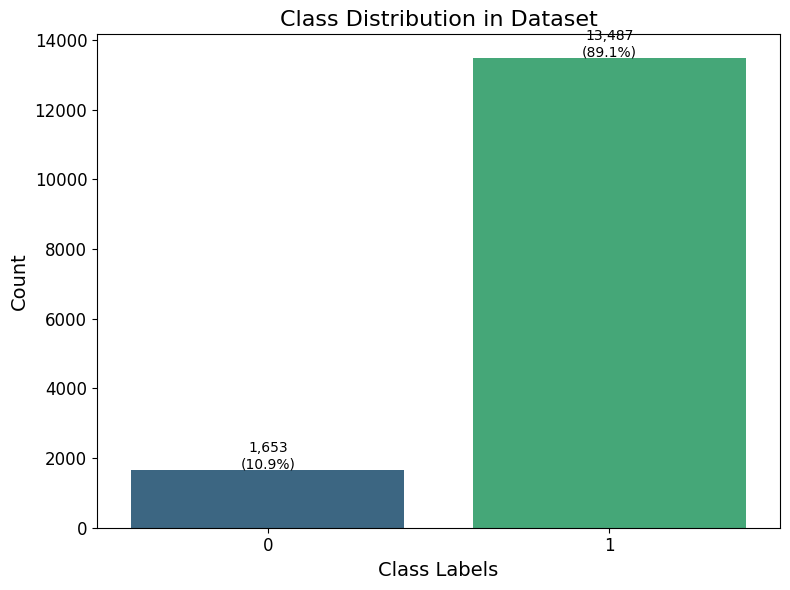

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get value counts
class_distribution = reviews_df['Rating_binary'].value_counts()

plt.figure(figsize=(8, 6))

# Bar plot
ax = sns.barplot(x=class_distribution.index, 
                 y=class_distribution.values,
                 palette="viridis")

# Add annotations
for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}\n({p.get_height()/len(reviews_df)*100:.1f}%)', 
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', 
                xytext=(0, 10), 
                textcoords='offset points')

# Customize plot
plt.title('Class Distribution in Dataset', fontsize=16)
plt.xlabel('Class Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.tight_layout()
plt.show()

In [3]:
# Get English stopwords
stop_words = set(stopwords.words('english'))
# Add 'nan' to the stopwords set
stop_words.add('nan')
print(stop_words)

{"it'd", 'yourselves', 'these', 'own', "he's", 'into', 'down', "don't", 'more', 'only', 'their', "we'd", 'how', 'from', 'so', 'against', 'is', "she'd", 'all', 'she', 'same', 'whom', "she's", "shan't", 'having', "i'm", 'but', "you're", 'off', 'of', 'again', 'were', "i've", "we've", 'below', 'should', "he'll", "that'll", 'yours', 'hadn', 'than', 'shan', 'those', "i'd", 'over', "we're", 'd', 'a', "they'll", 'had', "needn't", 'very', "we'll", 'yourself', 'ain', 'our', 'about', 'too', 'you', 're', 'does', 'ours', 'each', 'any', 'shouldn', 'we', 'to', 'll', "you'll", "mightn't", 'they', 'isn', 'further', 'just', 'above', 't', 'other', 'or', 'its', "hadn't", 'm', 'with', 'he', 'then', 'out', "wouldn't", 'doesn', 'when', 'now', 'him', 'this', 'don', "mustn't", 'who', "they'd", 'couldn', 'that', 'wasn', 'not', 'most', 'my', 'her', 'ourselves', 'through', "weren't", "doesn't", 'have', 'on', "hasn't", 'o', 'under', 'which', 'as', 'if', "won't", 'at', 'such', "you've", 'there', 'theirs', 'before',

In [4]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

#### Definition Pre-process Functions

In [5]:
def tokenize_text(df):
    # """ Step 1: Tokenization (Convert text into words) """
    df['Review'] = df['Review'].astype(str).apply(word_tokenize)
    return df

def remove_stopwords(df):
    # """ Step 2: Remove Stopwords & Special Characters """
    df['Review'] = df['Review'].apply(lambda tokens: [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words])
    return df

def lemmatize_text(df):
    # """ Step 3: Lemmatization (Convert words to their root form) """
    df['Review'] = df['Review'].apply(lambda tokens: [lemmatizer.lemmatize(word) for word in tokens])
    return df

def join_tokens(df):
    # """ Step 4: Join Tokens Back into a Sentence """
    df['Review'] = df['Review'].apply(lambda tokens: ' '.join(tokens))
    return df

def convert_to_tfidf(df):
    # """ Step 5: Convert Text to Numerical Format using TF-IDF """
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(df['Review'])
    return df, tfidf_matrix, vectorizer

#### Create an attention layer

In [6]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

class TextAttention(Layer):
    def __init__(self, **kwargs):
        super(TextAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        # input_shape: (batch, seq_len, emb_dim)
        self.emb_dim = input_shape[-1]
        
        # Attention weights
        self.W = self.add_weight(name="att_weight",
                               shape=(self.emb_dim, 1),
                               initializer="random_normal",
                               trainable=True)
        self.b = self.add_weight(name="att_bias",
                               shape=(1,),
                               initializer="zeros",
                               trainable=True)
        super(TextAttention, self).build(input_shape)

    def call(self, x):
        # Compute attention scores
        e = K.tanh(K.dot(x, self.W) + self.b)  # (batch, seq_len, 1)
        a = K.softmax(e, axis=1)  # (batch, seq_len, 1)
        
        # Weighted sum
        output = x * a  # (batch, seq_len, emb_dim)
        return K.sum(output, axis=1)  # (batch, emb_dim)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

#### Pre-process Data

In [7]:
reviews_df = tokenize_text(reviews_df)   # Tokenization
reviews_df.head()

,Game Name,Review,Rating_binary,Date
0,tryHackMe,"[It, 's, great, platform, for, fresher, to, st...",1,"Apr 7, 2025"
1,tryHackMe,"[A, great, Platform, to, start, for, non-IT, g...",1,"Apr 7, 2025"
2,tryHackMe,"[Well, explained, concept]",1,"Apr 6, 2025"
3,tryHackMe,"[The, tryhackme, platform, has, given, me, a, ...",1,"Apr 1, 2025"
4,tryHackMe,"[virtual, machines, freeze, every, few, minute...",0,"Apr 1, 2025"


In [8]:
reviews_df = remove_stopwords(reviews_df)  # Remove stopwords & special characters
reviews_df.head()

,Game Name,Review,Rating_binary,Date
0,tryHackMe,"[great, platform, fresher, start, journey, cyb...",1,"Apr 7, 2025"
1,tryHackMe,"[great, platform, start, guy, like]",1,"Apr 7, 2025"
2,tryHackMe,"[well, explained, concept]",1,"Apr 6, 2025"
3,tryHackMe,"[tryhackme, platform, given, renewed, awarenes...",1,"Apr 1, 2025"
4,tryHackMe,"[virtual, machines, freeze, every, minutes, re...",0,"Apr 1, 2025"


In [9]:
reviews_df = lemmatize_text(reviews_df)  # Lemmatization
reviews_df.head()

,Game Name,Review,Rating_binary,Date
0,tryHackMe,"[great, platform, fresher, start, journey, cyb...",1,"Apr 7, 2025"
1,tryHackMe,"[great, platform, start, guy, like]",1,"Apr 7, 2025"
2,tryHackMe,"[well, explained, concept]",1,"Apr 6, 2025"
3,tryHackMe,"[tryhackme, platform, given, renewed, awarenes...",1,"Apr 1, 2025"
4,tryHackMe,"[virtual, machine, freeze, every, minute, rese...",0,"Apr 1, 2025"


In [10]:
reviews_df = join_tokens(reviews_df)  # Join words back into text
reviews_df.head()

,Game Name,Review,Rating_binary,Date
0,tryHackMe,great platform fresher start journey cyber sec...,1,"Apr 7, 2025"
1,tryHackMe,great platform start guy like,1,"Apr 7, 2025"
2,tryHackMe,well explained concept,1,"Apr 6, 2025"
3,tryHackMe,tryhackme platform given renewed awareness hac...,1,"Apr 1, 2025"
4,tryHackMe,virtual machine freeze every minute reset dont...,0,"Apr 1, 2025"


In [11]:
reviews_df, tfidf_matrix, vectorizer = convert_to_tfidf(reviews_df)  # TF-IDF conversion
reviews_df.head()

,Game Name,Review,Rating_binary,Date
0,tryHackMe,great platform fresher start journey cyber sec...,1,"Apr 7, 2025"
1,tryHackMe,great platform start guy like,1,"Apr 7, 2025"
2,tryHackMe,well explained concept,1,"Apr 6, 2025"
3,tryHackMe,tryhackme platform given renewed awareness hac...,1,"Apr 1, 2025"
4,tryHackMe,virtual machine freeze every minute reset dont...,0,"Apr 1, 2025"


In [15]:
print(tfidf_matrix)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 405630 stored elements and shape (15140, 21097)>
  Coords	Values
  (0, 7830)	0.14982208662995705
  (0, 13270)	0.2710906980010294
  (0, 7103)	0.4957820248029534
  (0, 17043)	0.20599345289754067
  (0, 9829)	0.3262237041484951
  (0, 4093)	0.24422941811593282
  (0, 15838)	0.23536594370167635
  (0, 13590)	0.3854389700936886
  (0, 18074)	0.4957820248029534
  (1, 7830)	0.31041416984406695
  (1, 13270)	0.5616688157619897
  (1, 17043)	0.42679479449805957
  (1, 7961)	0.5810405488896291
  (1, 10383)	0.26155165550219805
  (2, 19824)	0.4096960077193987
  (2, 6305)	0.7489823231455665
  (2, 3388)	0.5207443335018218
  (3, 7830)	0.106265352843324
  (3, 13270)	0.19227838380581122
  (3, 18659)	0.1987141668344872
  (3, 7602)	0.18722659777587639
  (3, 14874)	0.3203710575601153
  (3, 1321)	0.31109446615642417
  (3, 7991)	0.12981748111618083
  (3, 10226)	0.3033428849770176
  :	:
  (15138, 14913)	0.3065277761538771
  (15139, 10383)	0.11589577351548

#### Tokenization

In [12]:
# Tokenization
tokenizer = Tokenizer(num_words=2000, oov_token="<OOV>")
tokenizer.fit_on_texts(reviews_df['Review'])
sequences = tokenizer.texts_to_sequences(reviews_df['Review'])

# Get the word index (word → index)
word_index = tokenizer.word_index

# Print the first 10 words
for word, index in list(word_index.items())[:10]:
    print(f"{word}: {index}")

# Save tokenizer to JSON
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(tokenizer_json)

<OOV>: 1
game: 2
like: 3
hacking: 4
get: 5
fun: 6
really: 7
one: 8
time: 9
good: 10


In [17]:
max_length = 150  # Adjust based on dataset
X = pad_sequences(sequences, maxlen=max_length)
y = reviews_df['Rating_binary'].values  # Target labels (0, 1)
print(y)

[1 1 1 ... 1 1 1]


In [18]:
for i, seq in enumerate(sequences[:10]):  # Print first 5 tokenized sequences
    print(f"Review {i+1}: {seq}")

Review 1: [12, 352, 1, 80, 987, 184, 172, 1, 1]
Review 2: [12, 352, 80, 415, 3]
Review 3: [31, 1168, 157]
Review 4: [355, 352, 306, 1, 1, 26, 94, 12, 94, 421, 1, 479, 52, 1, 1, 941, 211, 52]
Review 5: [795, 308, 1, 85, 346, 1482, 438, 163, 972, 346, 1544, 400, 346, 1, 1]
Review 6: [355, 259, 94, 66, 988, 1, 63, 276, 11, 119, 94, 515, 147, 1, 105, 22, 42, 1, 1378, 641, 168, 699, 14, 10, 107]
Review 7: [7, 10, 277, 542, 1, 184, 172]
Review 8: [1, 184, 172, 368, 325, 355, 915, 713, 31, 538, 276, 259, 160, 1, 1211, 828]
Review 9: [94, 352, 96, 180, 1545, 31, 1747, 201, 34, 352, 179, 796, 80, 1211, 255, 1, 691]
Review 10: [56, 688, 1979, 479, 255]


#### Split data

In [ ]:
# Split into train & test
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

#### Configure callback model optimizations

In [20]:
# Add ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# Add ModelCheckpoint callback
model_Checkpoint = ModelCheckpoint('model_1.keras', save_best_only=True)

#### Build the model structure

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, LayerNormalization
from tensorflow.keras.regularizers import l1_l2

model = Sequential([
    # Embedding layer with reduced vocab size
    Embedding(input_dim=2000, output_dim=128, input_length=150),

    # First Bidirectional LSTM layer (with layer norm and dropout)
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))),
    LayerNormalization(),

    # Second LSTM layer (not bidirectional to reduce complexity)
    LSTM(32, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    Dropout(0.4),

    # Fully connected layer
    Dense(64, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    Dropout(0.4),

    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])



c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


#### Compile Model

In [22]:
# Compile model
from tensorflow.keras.optimizers import Adam
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.00001), metrics=['accuracy'])
# loss='sparse_categorical_crossentropy'

#### Train Model

In [ ]:
# Train model
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr, early_stopping, model_Checkpoint],)

Epoch 1/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 48s 101ms/step - accuracy: 0.7544 - loss: 0.6852 - val_accuracy: 0.8857 - val_loss: 0.5106 - learning_rate: 1.0000e-05
Epoch 2/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 42s 98ms/step - accuracy: 0.8802 - loss: 0.5176 - val_accuracy: 0.8857 - val_loss: 0.4600 - learning_rate: 1.0000e-05
Epoch 3/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 42s 98ms/step - accuracy: 0.8888 - loss: 0.4735 - val_accuracy: 0.8857 - val_loss: 0.4479 - learning_rate: 1.0000e-05
Epoch 4/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - accuracy: 0.8923 - loss: 0.4586 - val_accuracy: 0.8857 - val_loss: 0.4423 - learning_rate: 1.0000e-05
Epoch 5/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 42s 100ms/step - accuracy: 0.8898 - loss: 0.4569 - val_accuracy: 0.8857 - val_loss: 0.4376 - learning_rate: 1.0000e-05
Epoch 6/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 44s 104ms/step - accuracy: 0.8840 - loss: 0.4567 - val_accuracy: 0.8857 - val_loss: 0.4328 - learning_rate: 1.0000e-05
Epoch 7/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 44s 102ms

#### Save Trained Model 

In [24]:
# After model.fit(), manually save the model
# (EarlyStopping has restored the best weights by now)
model.save('model_1.keras')

#### Save History Of Trained Model 

In [25]:
# save history of epochs

# Convert to DataFrame and save
history_df = pd.DataFrame(history.history)
history_df.to_csv('model_1_history.csv', index=False)

#### Classification Report

In [26]:
# Evaluate model
y_pred = (model.predict(X_test) >0.5).astype(int)
print(classification_report(y_test, y_pred))

48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step
              precision    recall  f1-score   support

           0       0.65      0.46      0.54       173
           1       0.93      0.97      0.95      1341

    accuracy                           0.91      1514
   macro avg       0.79      0.71      0.74      1514
weighted avg       0.90      0.91      0.90      1514



#### display the detailed architecture of the model

In [27]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 150, 128)       │       256,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 150, 128)       │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 150, 128)       │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,133,573 (4.32 MB)

 Trainable params: 377,857 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 755,716 (2.88 MB)

#### Track the model accuracy and loss

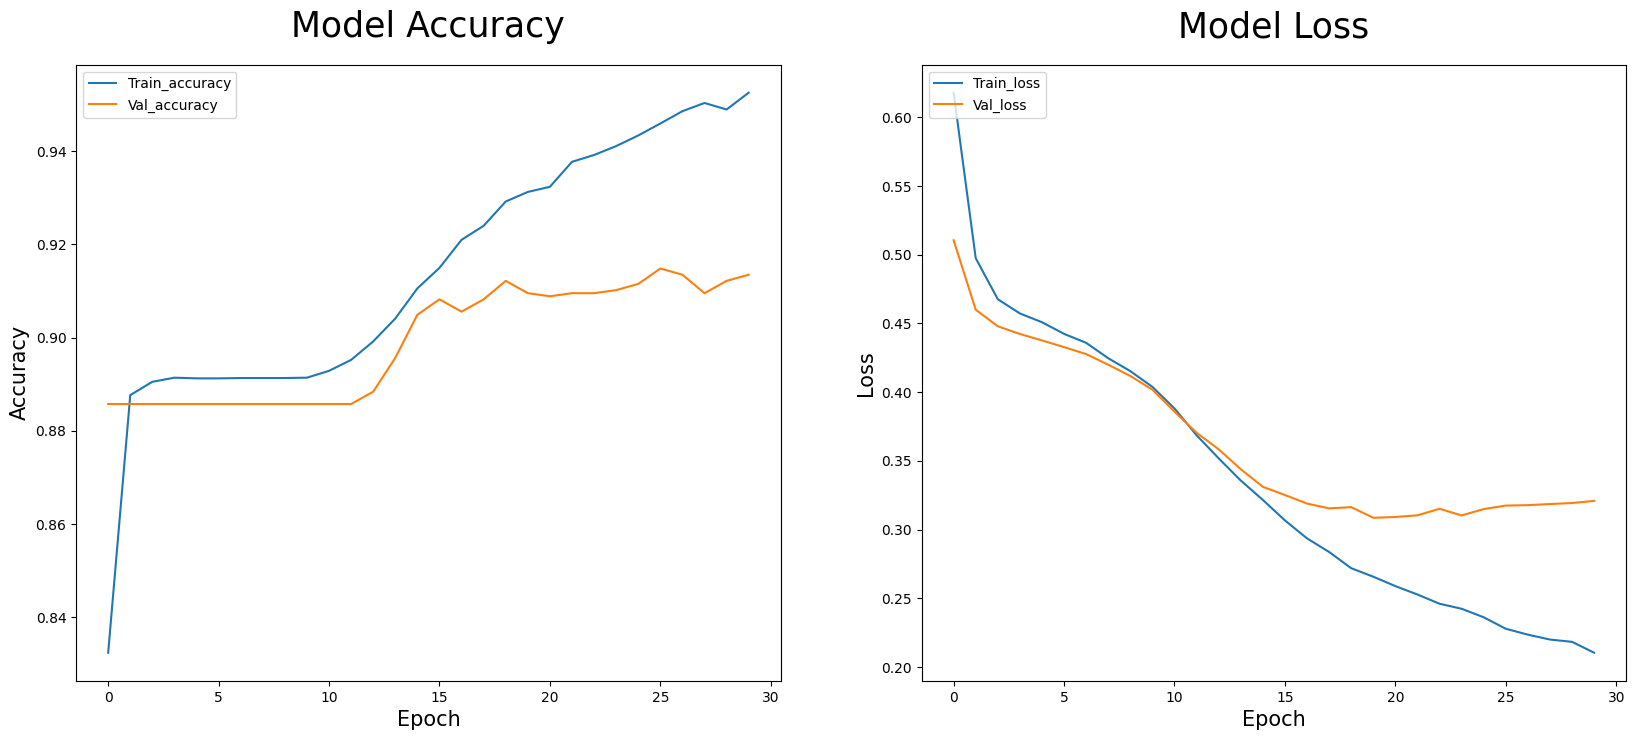

In [28]:
# Plotting the Model Accuracy & Model Loss vs Epochs (Hidden Input)
import matplotlib.pyplot as plt
plt.figure(figsize=[20,8])

# summarize history for accuracy
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'])
plt.plot(history_df['val_accuracy'])
plt.title('Model Accuracy', size=25, pad=20)
plt.ylabel('Accuracy', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['Train_accuracy', 'Val_accuracy'], loc='upper left')
# summarize history for loss

plt.subplot(1,2,2)
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.title('Model Loss', size=25, pad=20)
plt.ylabel('Loss', size=15)
plt.xlabel('Epoch', size=15)
plt.legend(['Train_loss', 'Val_loss'], loc='upper left')
plt.show()

c:\Users\DELL\AppData\Local\Programs\Python\Python312\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


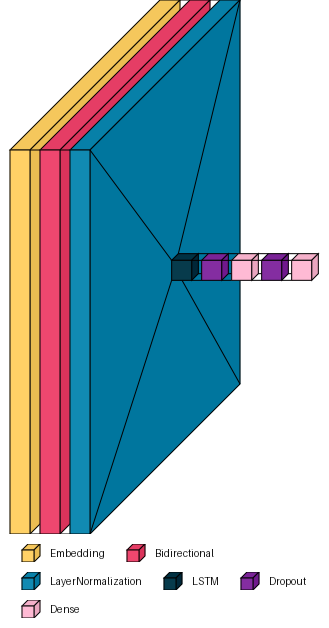

In [3]:
import visualkeras
from PIL import ImageFont
import tensorflow as tf

# Build/call your model if not already done
model(tf.zeros((1, 150)))  # if you haven't called it

# Optional font
try:
    font = ImageFont.truetype("arial.ttf", 14)
except:
    font = None

# Generate the image
visualkeras.layered_view(model, scale_xy=3, legend=True)

#### Load the trained model

In [13]:
from keras.models import load_model
from keras.utils import get_custom_objects

get_custom_objects().update({'TextAttention': TextAttention})

# Load the model
model = load_model('model_1.keras', custom_objects={'TextAttention': TextAttention})
# , custom_objects={'TextAttention': TextAttention}


 #### Load and sample random reviews

In [15]:
import pandas as pd

# Load the dataset
df = pd.read_csv("Reviews.csv")

df['Review'] = df['Review'].astype('string')
df = df.dropna(subset=['Rating_binary'])
df['Rating_binary'] = df['Rating_binary'].astype(int)

# View available columns (optional)
print(df.columns)

# Take 200 random samples
sample_df = df.sample(n=5000, random_state=42).reset_index(drop=True)

sample_df.head()


Index(['Game Name', 'Review', 'Rating_binary', 'Date'], dtype='object')


,Game Name,Review,Rating_binary,Date
0,tryHackMe,Been using this platform for about 5 months no...,1,"Nov 22, 2024"
1,NITE Team 4,"Played this game at a friends for 2 days, stru...",1,"Posted: August 2, 2020"
2,hackmud,"Fun game, helpful community, banger soundtrack...",1,"Posted: May 26, 2024"
3,EXAPUNKS,This is one of those games that might leave yo...,1,"Posted: 23 August, 2018"
4,Quadrilateral Cowboy,Brendon Chung is one of my favorite indie devs...,1,"Posted: 29 December, 2018"


#### Preprocess reviews for the model

In [16]:
def preProcess_Data(df):
    preProcessed_df = df.copy()
    # 1. First convert all text to strings (in case some are None or other types)
    preProcessed_df["Review"] = preProcessed_df["Review"].astype(str)

    # 2. Remove rows with empty strings or whitespace-only strings
    preProcessed_df = preProcessed_df[preProcessed_df["Review"].str.strip().ne('')]
    preProcessed_df = tokenize_text(preProcessed_df)
    preProcessed_df = remove_stopwords(preProcessed_df)
    preProcessed_df = lemmatize_text(preProcessed_df)
    preProcessed_df = join_tokens(preProcessed_df)
    preProcessed_df, tfidf_matrix, vectorizer = convert_to_tfidf(preProcessed_df)
    return preProcessed_df


#### Apply pre-process on sample reviews

In [19]:
processed_df = preProcess_Data(sample_df)
processed_df.head()

,Game Name,Review,Rating_binary,Date
0,tryHackMe,using platform month honestly say fun educatio...,1,"Nov 22, 2024"
1,NITE Team 4,played game friend day struggled greatly compl...,1,"Posted: August 2, 2020"
2,hackmud,fun game helpful community banger soundtrack g...,1,"Posted: May 26, 2024"
3,EXAPUNKS,one game might leave hungry much going worth a...,1,"Posted: 23 August, 2018"
4,Quadrilateral Cowboy,brendon chung one favorite indie devs disappoi...,1,"Posted: 29 December, 2018"


#### Tokenization on pre-processed data

In [17]:
from tensorflow.keras.preprocessing.text import tokenizer_from_json

# Load tokenizer from JSON
with open('tokenizer.json', 'r', encoding='utf-8') as f:
    tokenizer_data = f.read()
    tokenizer = tokenizer_from_json(tokenizer_data)

In [20]:

tokenizer.fit_on_texts(processed_df['Review'])
sequences = tokenizer.texts_to_sequences(processed_df['Review'])

# Get the word index (word → index)
word_index = tokenizer.word_index

# Pad sequences to max length (same as used in training)
x_input = pad_sequences(sequences, maxlen=150)

# Print the first 10 words
for word, index in list(word_index.items())[:100]:
    print(f"{word}: {index}")

# Usage:
print(f"Successfully created padded sequences: {x_input.shape}")

<OOV>: 1
game: 2
like: 3
hacking: 4
get: 5
fun: 6
really: 7
one: 8
time: 9
good: 10
puzzle: 11
great: 12
would: 13
make: 14
story: 15
feel: 16
play: 17
even: 18
thing: 19
way: 20
much: 21
also: 22
lot: 23
real: 24
command: 25
programming: 26
hacker: 27
hour: 28
mission: 29
want: 30
well: 31
first: 32
need: 33
recommend: 34
love: 35
work: 36
hack: 37
still: 38
know: 39
experience: 40
bit: 41
think: 42
use: 43
could: 44
played: 45
little: 46
computer: 47
find: 48
people: 49
playing: 50
learn: 51
go: 52
player: 53
pretty: 54
level: 55
best: 56
world: 57
gameplay: 58
got: 59
new: 60
give: 61
something: 62
see: 63
system: 64
interesting: 65
tool: 66
worth: 67
say: 68
hacknet: 69
code: 70
look: 71
though: 72
tutorial: 73
actually: 74
take: 75
ca: 76
better: 77
enough: 78
free: 79
file: 80
start: 81
many: 82
every: 83
uplink: 84
nice: 85
never: 86
buy: 87
far: 88
review: 89
hard: 90
back: 91
try: 92
learning: 93
amazing: 94
part: 95
around: 96
easy: 97
made: 98
ever: 99
point: 100
Successfull

#### Predict using the model

In [21]:
pred_probs = model.predict(x_input)
pred_classes = (pred_probs > 0.5).astype(int)
print(pred_probs)
print(pred_classes)

# Add predictions to DataFrame
processed_df["Predicted Label"] = pred_classes
# processed_df["Predicted Label"] = pred_labels
processed_df.head(100)




157/157 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step
[[0.9749191 ]
 [0.83640957]
 [0.9743252 ]
 ...
 [0.9686448 ]
 [0.9637557 ]
 [0.9276376 ]]
[[1]
 [1]
 [1]
 ...
 [1]
 [1]
 [1]]


,Game Name,Review,Rating_binary,Date,Predicted Label
0,tryHackMe,using platform month honestly say fun educatio...,1,"Nov 22, 2024",1
1,NITE Team 4,played game friend day struggled greatly compl...,1,"Posted: August 2, 2020",1
2,hackmud,fun game helpful community banger soundtrack g...,1,"Posted: May 26, 2024",1
3,EXAPUNKS,one game might leave hungry much going worth a...,1,"Posted: 23 August, 2018",1
4,Quadrilateral Cowboy,brendon chung one favorite indie devs disappoi...,1,"Posted: 29 December, 2018",1
...,...,...,...,...,...
95,Anonymous Hacker Simulator,hacking sim im blast,1,"Posted: 4 April, 2024",1
96,Quadrilateral Cowboy,first encounter game development shown trailer...,0,"Posted: 18 February, 2018",1
97,NITE Team 4,old school love terminal do bash powershell li...,1,"Posted: November 15, 2020",1
98,EXAPUNKS,boring chance get interesting concept could get,0,"Posted: 9 December, 2020",1


#### Save predictions to CSV

In [22]:
processed_df.to_csv("predicted_data.csv", index=False)
print("Saved predictions to predicted_amazon_reviews.csv")

Saved predictions to predicted_amazon_reviews.csv


#### Evaluate model accuracy (if ground truth is available)

In [23]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np

# Load your data
predicted_df = pd.read_csv('predicted_data.csv')
predicted_df.head()

# Define your class labels (adjust according to actual labels)
class_labels = [0, 1]  

# Transform labels to numerical values
true_classes = (predicted_df["Rating_binary"])
pred_classes = (predicted_df["Predicted Label"]) 

# # Calculate accuracy
accuracy = np.mean(true_classes == pred_classes)
print(f"Accuracy on {len(predicted_df)} reviews: {accuracy:.4f}")

Accuracy on 5000 reviews: 0.8714


#### Confusion Matrix For Predicted Data

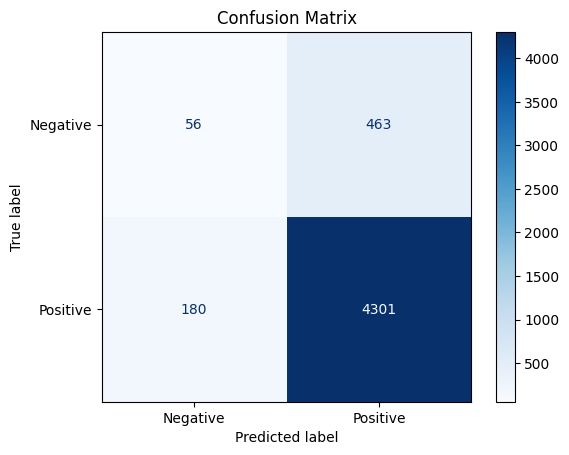

In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Make sure labels are integers
true_classes = predicted_df["Rating_binary"].astype(int)
pred_classes = predicted_df["Predicted Label"].astype(int)

# Compute confusion matrix
cm = confusion_matrix(true_classes, pred_classes, labels=[0, 1])

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
